In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from data_parsing import load_trajectories
from functools import partial, reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
# from glob import glob
# import os

In [3]:
#trajectories, status = load_trajectories('data/MITxPRO+AMxB+1T2018/edges', 'data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
trajectories, status = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL', 'data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
#trajectories = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL')
#id_and_performance = pd.read_csv('data/MITxPRO-AMxB-1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance.iloc[0]
#id_and_performance

In [4]:
# AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')

Maximum trajectory identified by number of clicks:  1699


Text(0, 0.5, 'Count of students')

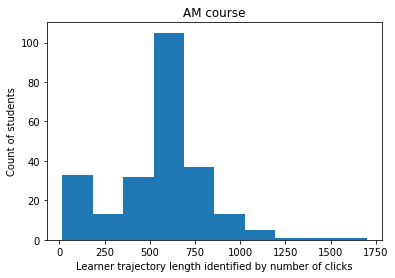

In [5]:
traj_lengths = trajectories.map(len).values
plt.hist(traj_lengths)
print("Maximum trajectory identified by number of clicks: ", max(traj_lengths))
plt.title('AM course')
plt.xlabel('Learner trajectory length identified by number of clicks')
plt.ylabel('Count of students')

## data generators 

In [6]:
index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)

incoming_traj = []
outgoing_traj = []

# this split assumes that we don't need to rebalance for unequal category weights
n_valid = int(2*np.sqrt(len(trajectories)))
n_train = len(trajectories) - n_valid
success_rate = status[index[:n_train]].sum() / n_train

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

def data_generator(start, stop, use_status):
     while True:
        for i in range(start, stop):        
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            y = outgoing_traj[index[i]].reshape(1,-1)
            if use_status:
                yield [x,s],y
            else:
                yield x,y

train_generator_simp = partial(data_generator, 0, n_train, False)
valid_generator_simp = partial(data_generator, n_train, n_train+n_valid, False)
train_generator_cond = partial(data_generator, 0, n_train, True)
valid_generator_cond = partial(data_generator, n_train, n_train+n_valid, True)
success_rate

0.06190476190476191

## Define models

In [7]:
hidden_dim = 37
embedding_dim = 30
# turning trajectories into sets of URLs
optimizer = Adam(learning_rate=0.001)
number_of_URL = max(trajectories.sum()) + 1
#number_of_URL = 1121

In [8]:
input_ = Input(shape=(None,), name='history')
embed = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed)

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(rnn)

model_simp = Model(inputs=input_, outputs=predicted_URL, name='Simple_model')
model_simp.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_simp.summary()

Model: "Simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
history (InputLayer)         [(None, None)]            0         
_________________________________________________________________
URL_embedding (Embedding)    (None, None, 30)          13980     
_________________________________________________________________
LSTM (LSTM)                  (None, None, 37)          10064     
_________________________________________________________________
Predicted_URL (Dense)        (None, None, 466)         17708     
Total params: 41,752
Trainable params: 41,752
Non-trainable params: 0
_________________________________________________________________


In [9]:
input_x = Input(shape=(None,), name='history')
input_s = Input(shape=(None,), name='status')
embed_x = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_x)
embed_s = Embedding(2, hidden_dim, embeddings_initializer='ones', name='Status_embedding')(input_s)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed_x)
masked = Multiply()([rnn, embed_s])

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(masked)

model_cond = Model(inputs=[input_x, input_s], outputs=predicted_URL, name='Conditional_model')
model_cond.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_cond.summary()

Model: "Conditional_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
history (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
URL_embedding (Embedding)       (None, None, 30)     13980       history[0][0]                    
__________________________________________________________________________________________________
status (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, None, 37)     10064       URL_embedding[0][0]              
__________________________________________________________________________________

## Run models

In [10]:
#model_simp.load_weights('weights_simp.h5')
#model_cond.load_weights('LaaL_cond_hiddim30-.hdf5', by_name=True)

In [ ]:
filepath="LaaL_simp_hiddim37-.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model_simp.fit_generator(train_generator_cond(), 
                    validation_data=valid_generator_cond(),
                    callbacks=callbacks_list,
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=100,
                    verbose=1,)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 210 steps, validate for 31 steps
Epoch 1/100
209/210 [============================>.] - ETA: 0s - loss: 5.6547 - acc: 0.0187
Epoch 00001: val_loss improved from inf to 5.30203, saving model to LaaL_simp_hiddim37-.hdf5
210/210 [==============================] - 54s 255ms/step - loss: 5.6532 - acc: 0.0187 - val_loss: 5.3020 - val_acc: 0.0319
Epoch 2/100
209/210 [============================>.] - ETA: 0s - loss: 4.8569 - acc: 0.0518
Epoch 00002: val_loss improved from 5.30203 to 4.50168, saving model to LaaL_simp_hiddim37-.hdf5
210/210 [==============================] - 50s 239ms/step - loss: 4.8551 - acc: 0.0520 - val_loss: 4.5017 - val_acc: 0.0839
Epoch 3/100
209/210 [============================>.] - ETA: 0s - loss: 4.0718 - acc: 0.1099
Epoch 00003: val_loss improved from 4.50168 to 3.71655, saving model to LaaL_simp_hiddim37-.hdf5
210/210 [===========

Epoch 26/100
209/210 [============================>.] - ETA: 0s - loss: 1.2093 - acc: 0.6521
Epoch 00026: val_loss improved from 1.31089 to 1.30313, saving model to LaaL_simp_hiddim37-.hdf5
210/210 [==============================] - 49s 232ms/step - loss: 1.2099 - acc: 0.6519 - val_loss: 1.3031 - val_acc: 0.6497
Epoch 27/100
209/210 [============================>.] - ETA: 0s - loss: 1.1994 - acc: 0.6544
Epoch 00027: val_loss improved from 1.30313 to 1.29610, saving model to LaaL_simp_hiddim37-.hdf5
210/210 [==============================] - 49s 232ms/step - loss: 1.2000 - acc: 0.6542 - val_loss: 1.2961 - val_acc: 0.6511
Epoch 28/100
209/210 [============================>.] - ETA: 0s - loss: 1.1901 - acc: 0.6561
Epoch 00028: val_loss improved from 1.29610 to 1.28989, saving model to LaaL_simp_hiddim37-.hdf5
210/210 [==============================] - 49s 233ms/step - loss: 1.1907 - acc: 0.6560 - val_loss: 1.2899 - val_acc: 0.6520
Epoch 29/100
209/210 [============================>.] - ET

## Sample trajectory creation 

In [ ]:
proposed_traj = [0]
visit_count = defaultdict(int)
max_allowed_visits = 25

while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
    x = np.array(proposed_traj).reshape(1,-1)
    #run with s = np.ones(x.shpae) for successful
    s = np.ones(x.shape)
    for url in reversed(np.argsort(model_cond.predict([x,s])[0,-1])):
        if visit_count[url] < max_allowed_visits:
            proposed_traj.append(url)
            visit_count[url] += 1
            break
    #predicted = np.argmax(model.predict(x)[0,-1])
    print(url)
    
print(proposed_traj)

cert_traj = pd.DataFrame(proposed_traj)
cert_traj.to_csv('LaaL_cert_traj_hid_dim30.csv', header = ['certificate trajectory'], index = False)

## Probability estimation

In [ ]:
def score_traj(sample_traj):
    x = np.array(sample_traj[:-1]).reshape(1,-1)
    successful = np.ones(x.shape)
    unsuccessful = np.ones(x.shape)
    cond_prob_successful = np.array(model_cond([x, successful])).reshape(-1, number_of_URL)
    cond_prob_unsuccessful = np.array(model_cond([x, unsuccessful])).reshape(-1, number_of_URL)

    score_s = []
    score_u = []

    for choice, prob_s, prob_u in zip(sample_traj[1:], cond_prob_successful, cond_prob_unsuccessful):
        score_s.append(np.log(prob_s[choice]))
        score_u.append(np.log(prob_u[choice]))
    return score_s, score_u



In [ ]:
def predict_success(traj):
    score_s, score_u = score_traj(traj)
    evidence_s = np.log(success_rate) + np.sum(score_s)
    evidence_u = np.log(1 - success_rate) + np.sum(score_u)
    prob_of_success = 1 / (1 + np.exp(evidence_u - evidence_s))
    return prob_of_success

In [ ]:
for i in range(n_train, n_train+n_valid):
    user = index[i]
    traj = trajectories.iloc[user]
    ground_truth = status[user]
    print(ground_truth, predict_success(traj))

In [ ]:
# # user list key - session level
# AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
# AM_userList

# # learning pathway network edge lists - edge list for each student in the course that represent a directed 
# # transitions networks  of students pathway through the courses content modules.  this is all students.
# AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
# AM_edgelist[:5]

In [ ]:
incoming_traj[0].shape

In [ ]:
model.predict([0,1,3,4,5,6])[0,-1].tolist()

In [ ]:
x = np.array([0,1,2,3,4,5,6]).reshape(1,-1)
s = np.zeros(x.shape)
model2.predict([x,s])[0,-1].tolist()

In [ ]:
np.argsort([7,5,1,2])

In [ ]:
# node list of all students' learning pathway networks
AM_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

In [ ]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

In [ ]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance['certGrp'].unique()

In [ ]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

In [ ]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data

# LaaL_edgelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

LaaL_modules = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules00.csv')
len(LaaL_modules)
LaaL_modules[460:470]

In [ ]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

In [ ]:
LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

In [ ]:
LaaL_node_coord = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

In [ ]:
LaaL_id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]

count = LaaL_id_and_performance[LaaL_id_and_performance['certGrp']== 'Certified (< 65% Grade)']
len(count)